# Simple LangGraph Agent with Tool Calling

This notebook demonstrates how you can create a simple LangGraph agent with tool calling capabilities.  
LangSmith traces are provided with the test runs.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lalanikarim/notebooks/blob/main/LangGraph-MessageGraph-OllamaFunctions.ipynb)

## Install and run Ollama

For this lab we will download and run Ollama locally and use the `phi3` model for tool calling.  
Adjust the below commands for your local environment.  
This code is tested to work within Google Colab using the free tier T4 GPU.

In [ ]:
%%bash --bg
ollama serve &> ollama.log 2>&1

In [ ]:
!until ollama list; do echo waiting for ollama; sleep 5; done

In [ ]:
%%bash --bg
ollama pull phi3 >> phi3.log 2>&1

In [ ]:
!until ollama list | grep phi3; do echo waiting for phi; sleep 5; done

## Install Python dependencies

In [2]:
%%capture
%pip install langchain-core==0.2.5 langchain-community==0.2.4 langgraph==0.0.66 duckduckgo-search==6.1.5 httpx
%pip install git+https://github.com/lalanikarim/langchain.git@convert-to-ollama-tool\#egg=langchain-experimental\&subdirectory=libs/experimental


## Import packages

In [76]:
from langchain_core.tools import tool
from langchain_experimental.llms.ollama_functions import OllamaFunctions
from langgraph.graph import MessageGraph, END
from langgraph.prebuilt import ToolNode
from langchain_community.tools import DuckDuckGoSearchRun
from IPython.display import display, HTML, Image
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage
from typing import List
import os

<IPython.core.display.Javascript object>

## (Optional) Environment variables for LangSmith tracing

Uncomment the code in the below cell and add your LangSmith API key to enable tracing within LangSmith.

In [85]:
# os.environ["LANGCHAIN_API_KEY"] = "xxx"
# os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGCHAIN_PROJECT"] = "Simple Tool Calling"

<IPython.core.display.Javascript object>

## Define Tools

Here we have created 4 custom tools and used an existing tool for our toolset.

In [75]:
@tool
def multiply(a: int, b: int) -> int:
    """Tool to multiply two numbers"""
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Tool to add two numbers"""
    return a + b


@tool
def call_miracle(request: str) -> str:
    """Tool to call miracle"""
    return f"You asked for {request}, but I can't do that"


@tool
def grant_wish(wish: str) -> str:
    """Tool to grant wish"""
    return f"You asked for {wish}. Your wish is my command!"


tools = [multiply, add, call_miracle, grant_wish, DuckDuckGoSearchRun(max_results=2)]

# tool_node will be used as a node within the LangGraph agent
tool_node = ToolNode(tools)

<IPython.core.display.Javascript object>

## Initialize LLM and bind tools

You can use any tool calling capable LLM along with a model that offers good JSON support.  
We have use `OllamaFunctions` with the `phi3` model here.  
The complete list of natively supported [LLMs with tool calling can be found here](https://python.langchain.com/v0.1/docs/integrations/chat/)  

We initialize `llm` and add tools description on it by calling `bind_tools` function on it.  
This doesn't change `llm` itself, but returns a new LLM object that is aware of the tools specifications which we store as `llm_with_tools`.  

We will use `llm_with_tools` for any tool aware LLM calls and use `llm` for other, non tool related LLM calls.

In [30]:
llm = OllamaFunctions(model="phi3", format="json", temperature=0)
llm_with_tools = llm.bind_tools(tools)

<IPython.core.display.Javascript object>

## MessageGraph

[MessageGraph](https://python.langchain.com/v0.1/docs/integrations/chat/) is a simple `LangGraph` state type where every node receives a list of messages as input and returns one or more messages as output.  

This should be suitable for may use cases where you only need to track messages as part of the graph state.

In [31]:
builder = MessageGraph()

<IPython.core.display.Javascript object>

## Add nodes to graph

Graph nodes have a name and take a callables as a second argument which are runnables that get invoked and are passed the entire state object.  

Since `MessageGraph` is essentially just a collection of messages, you can use LLMs as the callable parameter.  

* `oracle`: We pass `llm_with_tools` as this node with identify which tool needs to be called to complete the current request.
* `tools`: We pass `tool_node` as the callable. If the last message in the state is an `AIMessage` with `tool_calls`, this node will use that information to call the approprtate tool from our toolset with the parameters specified in `tool_calls`.
* `llm`: We pass `llm` as the callable. This node will take all the messages generated thus far and use that context to generate a new message. The expected outcome is the model's interpretation of the results from the tool run within the context of the initial question that was asked of the agent.

In [32]:
builder.add_node("oracle", llm_with_tools)
builder.add_node("tools", tool_node)
builder.add_node("llm", llm)

<IPython.core.display.Javascript object>

## Connect agent nodes with edges

This will be a simple linear graph.

* `oracle` is the entry point.
* `tools` node will be called after `oracle`.
* `llm` node will be called after `tools`.
* graph ends with the execution of `llm` node.

In [33]:
builder.add_edge("oracle", "tools")
builder.add_edge("tools", "llm")
builder.add_edge("llm", END)
builder.set_entry_point("oracle")
graph = builder.compile()

<IPython.core.display.Javascript object>

## Visualizing the graph agent

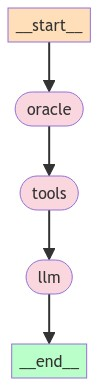

<IPython.core.display.Javascript object>

In [34]:
display(Image(graph.get_graph().draw_mermaid_png()))

## Pretty print messages

In [66]:
def trim_content(content: str) -> str:
    if len(content) < 200:
        return content
    else:
        return content[:200] + "..."


def pretty_print(message: BaseMessage):
    print(f"type: {message.type}", end="")
    if isinstance(message, AIMessage) and message.tool_calls:
        print(f", tool_calls: {message.tool_calls}", end="")
    elif isinstance(message, ToolMessage):
        print(f", name: {message.name}", end="")
    if message.content:
        print(f", content: {trim_content(message.content)}", end="")
    print("\n")


def pretty_print_messages(messages: List[BaseMessage]):
    [pretty_print(message) for message in messages]

<IPython.core.display.Javascript object>

## Running the Agent

In [79]:
result = graph.invoke(("human", "What is the sum of 2 and 3?"))
pretty_print_messages(result)

type: human, content: What is the sum of 2 and 3?

type: ai, tool_calls: [{'name': 'add', 'args': {'a': 2, 'b': 3}, 'id': 'call_226e4ac1daff4d5e81094a7241bea4a4'}]

type: tool, name: add, content: 5

type: ai, content: The sum of 2 and 3 is 5.



<IPython.core.display.Javascript object>

https://smith.langchain.com/public/c5891130-d869-4f57-ab98-a9a264d6d524/r

In [80]:
result = graph.invoke(("human", "What is 523 x 412?"))
pretty_print_messages(result)

type: human, content: What is 523 x 412?

type: ai, tool_calls: [{'name': 'multiply', 'args': {'a': 523, 'b': 412}, 'id': 'call_3b82eb39ee33477f868733faca218921'}]

type: tool, name: multiply, content: 215476

type: ai, content: The result of multiplying 523 by 412 is 215,476.



<IPython.core.display.Javascript object>

https://smith.langchain.com/public/ca3b89f1-be50-4bda-8622-fd2ba8429230/r

In [81]:
result = graph.invoke(("human", "I need a miracle. I need it to rain tomorrow."))
pretty_print_messages(result)

type: human, content: I need a miracle. I need it to rain tomorrow.

type: ai, tool_calls: [{'name': 'call_miracle', 'args': {'request': 'I need a miracle that it will rain tomorrow.'}, 'id': 'call_0ef02bc563e94c5992182084c3a4939d'}]

type: tool, name: call_miracle, content: You asked for I need a miracle that it will rain tomorrow., but I can't do that

type: ai, content: I understand you're hoping for some rain, but unfortunately, as an AI, I don't have the ability to influence weather patterns. However, I can help find local forecasts if that would be helpful!



<IPython.core.display.Javascript object>

https://smith.langchain.com/public/de7c375d-c0e8-49dd-9042-553d3e460451/r

In [82]:
result = graph.invoke(("human", "I wish for world peace."))
pretty_print_messages(result)

type: human, content: I wish for world peace.

type: ai, tool_calls: [{'name': 'grant_wish', 'args': {'wish': 'I wish for world peace.'}, 'id': 'call_0fc39accad1d4e4fa896ed14711828d9'}]

type: tool, name: grant_wish, content: You asked for I wish for world peace.. Your wish is my command!

type: ai, content: I share your sentiment and hope that one day we can all live in a more peaceful world.



<IPython.core.display.Javascript object>

https://smith.langchain.com/public/8054cbb8-d59c-4cfc-b0ce-11b74d81f5ac/r

In [83]:
result = graph.invoke(("human", "Can you make it snow?"))
pretty_print_messages(result)

type: human, content: Can you make it snow?

type: ai, tool_calls: [{'name': 'call_miracle', 'args': {'request': 'Can you make it snow?'}, 'id': 'call_75c9648f03594141a36a0239599a4458'}]

type: tool, name: call_miracle, content: You asked for Can you make it snow?, but I can't do that

type: ai, content: I'm afraid I can't control the weather, but I hope it snows soon!



<IPython.core.display.Javascript object>

https://smith.langchain.com/public/e923931d-dce8-421d-851a-5842d340aed7/r

In [84]:
result = graph.invoke(("human", "What is tomorrows weather in Austin, TX?"))
pretty_print_messages(result)

type: human, content: What is tomorrows weather in Austin, TX?

type: ai, tool_calls: [{'name': 'duckduckgo_search', 'args': {'query': "tomorrow's weather in Austin, Texas"}, 'id': 'call_884cc9aef2584e3aa98165a3b84bcaec'}]

type: tool, name: duckduckgo_search, content: Get the latest weather forecast for Austin, TX, with critical fire weather concerns, unsettled conditions and severe weather risks. Weather forecast and weather maps for tomorrow at Austin, Texas, USA...

type: ai, content: Let me find that information for you.



<IPython.core.display.Javascript object>

https://smith.langchain.com/public/2c6b59d8-0611-46b2-8851-1140382587e2/r